In [415]:
# utility
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import norm, probplot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

dataset = arff.loadarff('./data/ames_housing.arff')
data = pd.DataFrame(dataset[0])

print("Number of rows in the data:", data.shape[0])
print("Number of columns in the data:", data.shape[1])

Number of rows in the data: 2930
Number of columns in the data: 81


## First data engineering
We drop Pool_Qc feature, beacuse is information is already described by the feature Pool_Area

In [416]:
data = data.drop(labels='Pool_QC', axis=1)

# Refine data
controllo se Neighborhood che ha tati valori ha un qualche ordinamento e in caso la trasformo in numerica

<AxesSubplot: xlabel='Neighborhood', ylabel='Sale_Price'>

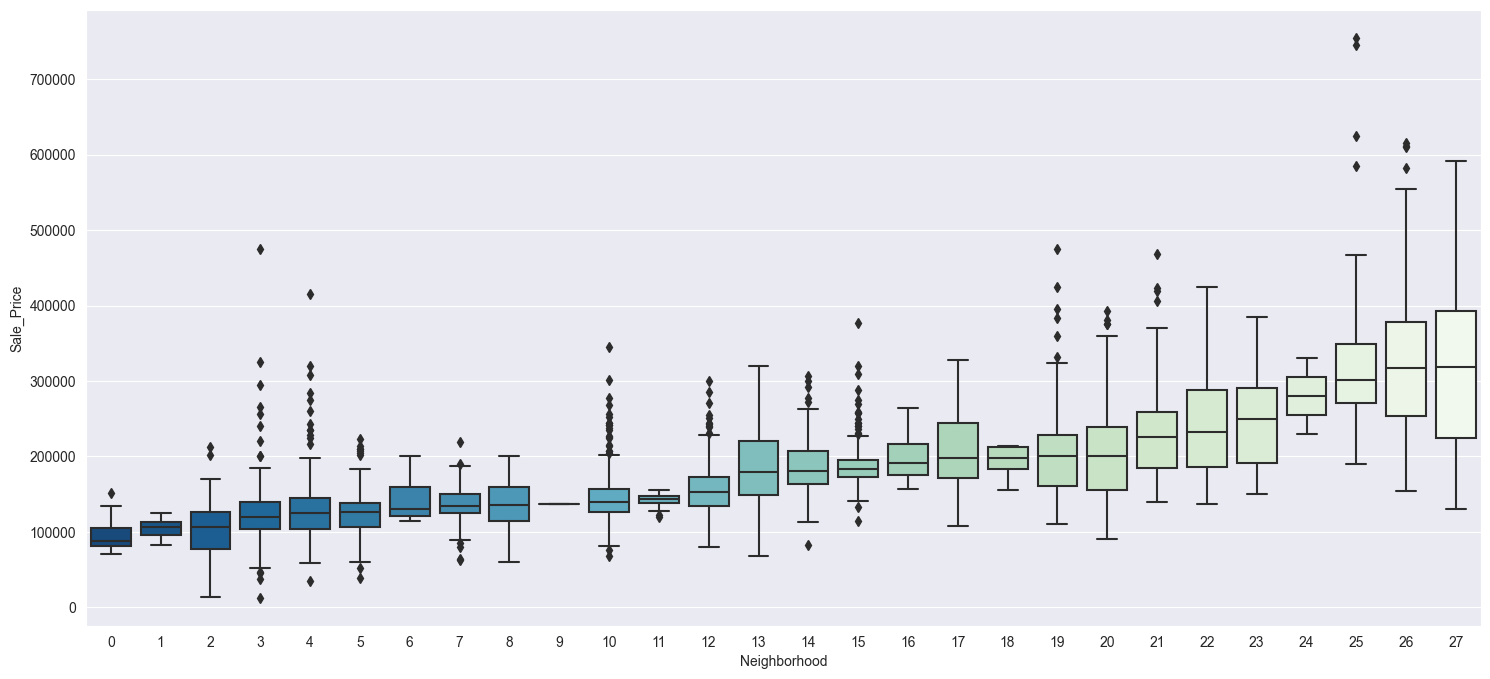

In [417]:
# Descending order of levels sorted by median SalePrice
featOrder = data.groupby(['Neighborhood']).median().Sale_Price.sort_values(ascending=True).index

# replace con l'ordinamento trovato
neighborhoodOrder = dict(zip(featOrder, range(len(featOrder.to_list()))))
data = data.replace({'Neighborhood': neighborhoodOrder})

# Create box plot
plt.figure(figsize=(18, 8))
sns.boxplot(x='Neighborhood',
            y='Sale_Price',
            data=data,
            palette='GnBu_r')

stessa cosa per Overall_Qual e Overall_Cond

{b'Very_Poor': 0, b'Poor': 1, b'Fair': 2, b'Below_Average': 3, b'Average': 4, b'Above_Average': 5, b'Good': 6, b'Very_Good': 7, b'Excellent': 8, b'Very_Excellent': 9}


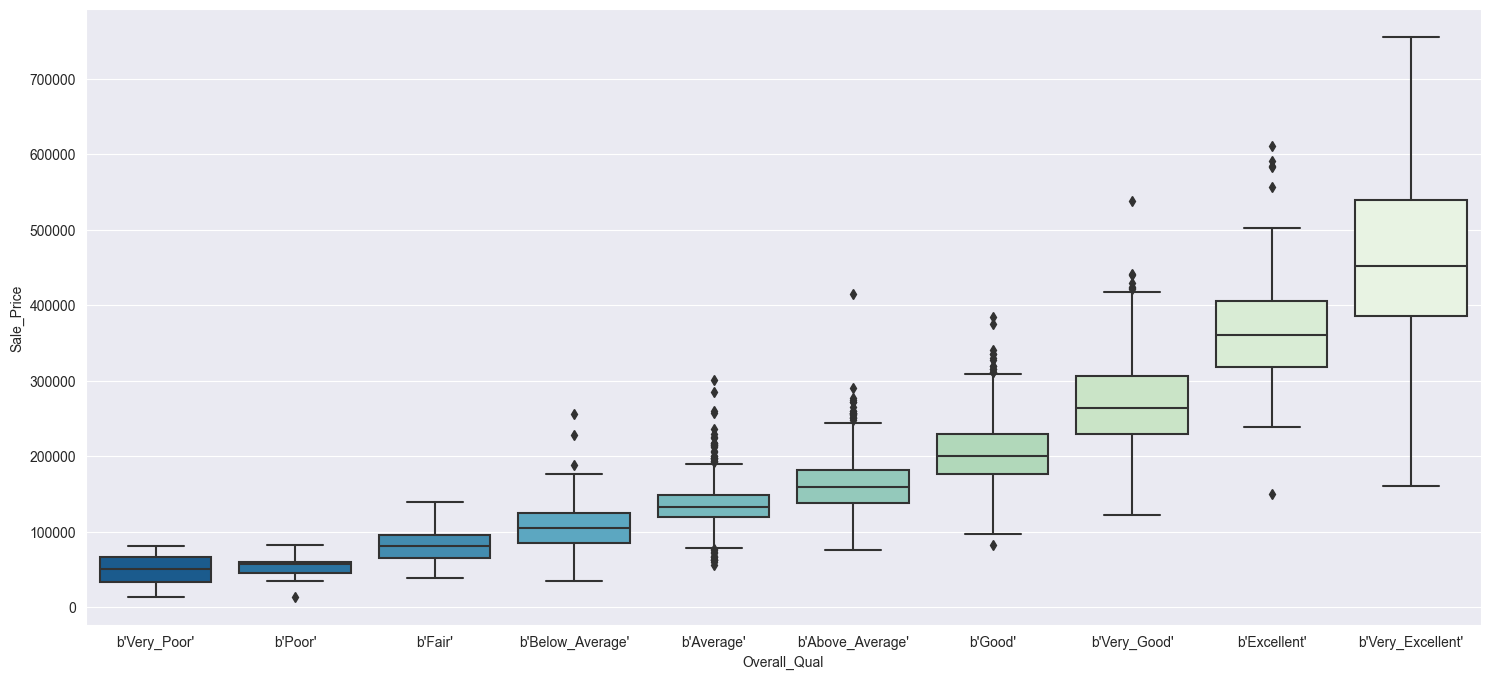

In [418]:
# Descending order of levels sorted by median SalePrice
featOrder = data.groupby(['Overall_Qual']).median().Sale_Price.sort_values(ascending=True).index

# Create box plot
plt.figure(figsize=(18, 8))
sns.boxplot(x='Overall_Qual',
            y='Sale_Price',
            data=data,
            order=featOrder,
            palette='GnBu_r')

# replace con l'ordinamento trovato
Overall_QualOrder = dict(zip(featOrder, range(len(featOrder.to_list()))))
print(Overall_QualOrder)
data = data.replace({'Overall_Qual': Overall_QualOrder})

{b'Very_Poor': 0, b'Fair': 1, b'Poor': 2, b'Below_Average': 3, b'Good': 4, b'Very_Good': 5, b'Above_Average': 6, b'Excellent': 7, b'Average': 8}


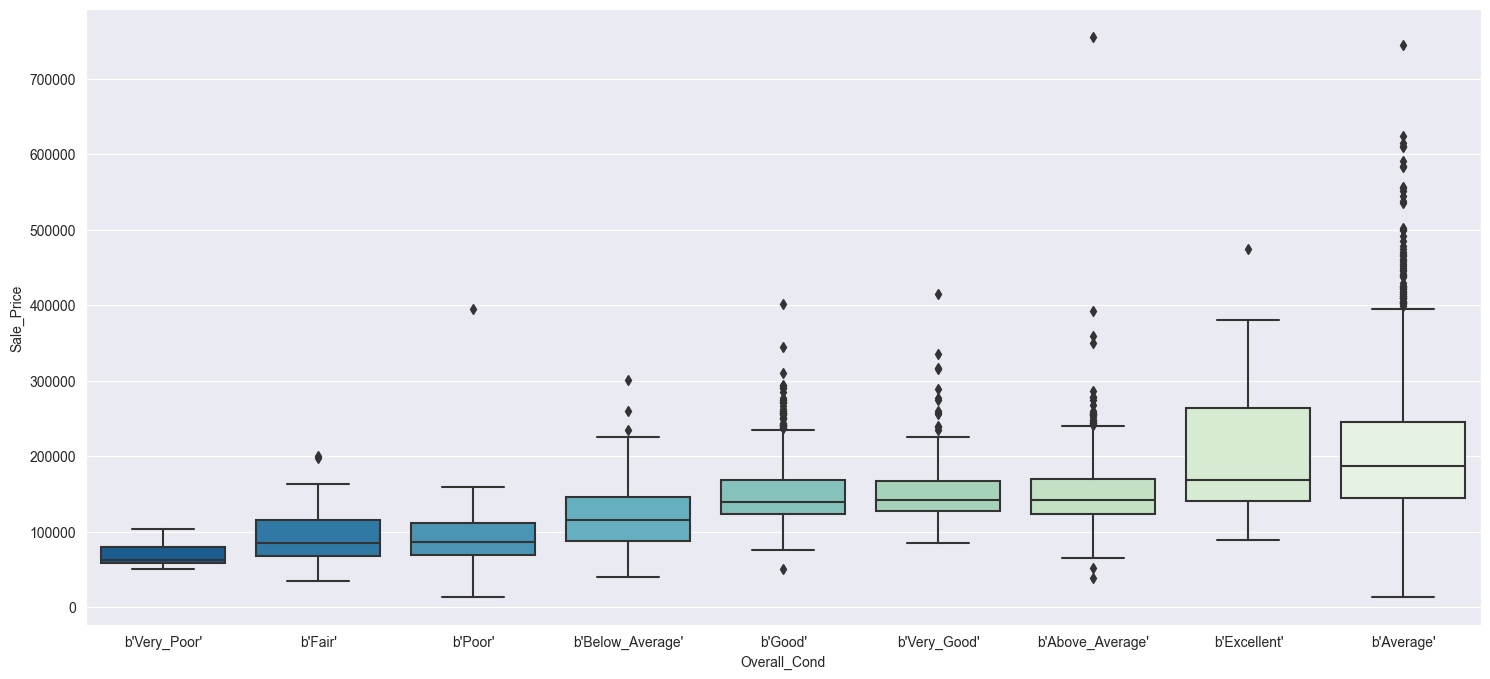

In [419]:
# Descending order of levels sorted by median SalePrice
featOrder = data.groupby(['Overall_Cond']).median().Sale_Price.sort_values(ascending=True).index

# Create box plot
plt.figure(figsize=(18, 8))
sns.boxplot(x='Overall_Cond',
            y='Sale_Price',
            data=data,
            order=featOrder,
            palette='GnBu_r')

# replace con l'ordinamento trovato
Overall_CondOrder = dict(zip(featOrder, range(len(featOrder.to_list()))))
print(Overall_CondOrder)
data = data.replace({'Overall_Cond': Overall_CondOrder})

trasformiamo le variabili categoriche che hanno un andamento crescente

In [420]:
#TODO: controllare 'fair', 'Typical'
def refineData(df):
    replace = {
        "Kitchen_Qual": {b'Poor': 0, b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Utilities": {b'AllPub': 1, b'NoSewr': 2, b'NoSeWa': 3},
        "Land_Slope": {b'Gtl': 1, b'Mod': 2, b'Sev': 3},
        "Exter_Qual": {b'Fair': 1, b'Typical': 2, b'Good': 3, b'Excellent': 4},
        "Exter_Cond": {b'Poor': 1, b'Fair': 2, b'Typical': 3, b'Good': 4, b'Excellent': 4},
    }
    new_data = df.replace(replace)
    return new_data


data = refineData(data)

# Outliers

<AxesSubplot: xlabel='Overall_Qual', ylabel='Sale_Price'>

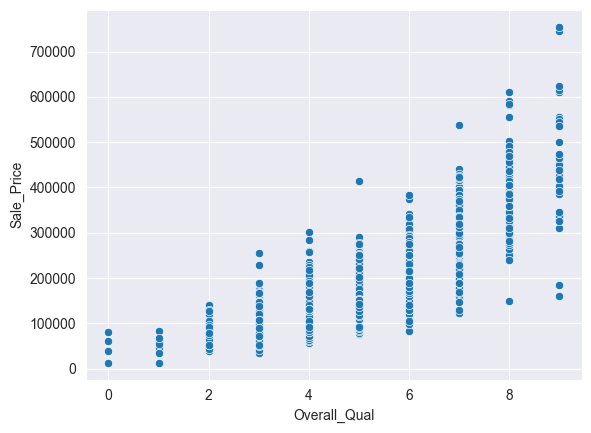

In [421]:
sns.scatterplot(x='Overall_Qual',y='Sale_Price',data=data)

In [422]:
data[(data["Sale_Price"] < 200000) & (data["Overall_Qual"] > 8) & (data["Gr_Liv_Area"] > 4000)]

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
1498,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',313.0,63887.0,b'Pave',b'No_Alley_Access',b'Irregular',b'Bnk',1,b'Corner',...,b'No_Fence',b'None',0.0,1.0,2008.0,b'New',b'Partial',160000.0,-93.674898,42.016804
2180,b'One_Story_1946_and_Newer_All_Styles',b'Residential_Low_Density',128.0,39290.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Bnk',1,b'Inside',...,b'No_Fence',b'Elev',17000.0,10.0,2007.0,b'New',b'Partial',183850.0,-93.676220,42.016453
2181,b'Two_Story_1946_and_Newer',b'Residential_Low_Density',130.0,40094.0,b'Pave',b'No_Alley_Access',b'Slightly_Irregular',b'Bnk',1,b'Inside',...,b'No_Fence',b'None',0.0,10.0,2007.0,b'New',b'Partial',184750.0,-93.676241,42.016642


In [423]:
drop_index = data[(data["Sale_Price"] < 200000) & (data["Overall_Qual"] > 8) & (data["Gr_Liv_Area"] > 4000)].index
data = data.drop(drop_index, axis = 0)

# Sale Price normalization

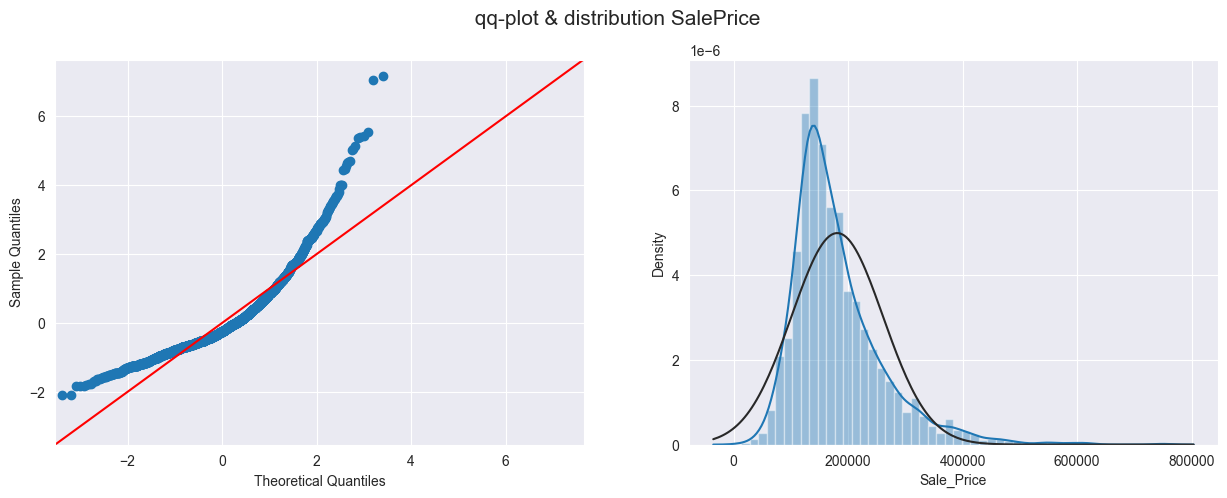

In [424]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(" qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(data.Sale_Price, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(data.Sale_Price, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

try with log-transformation

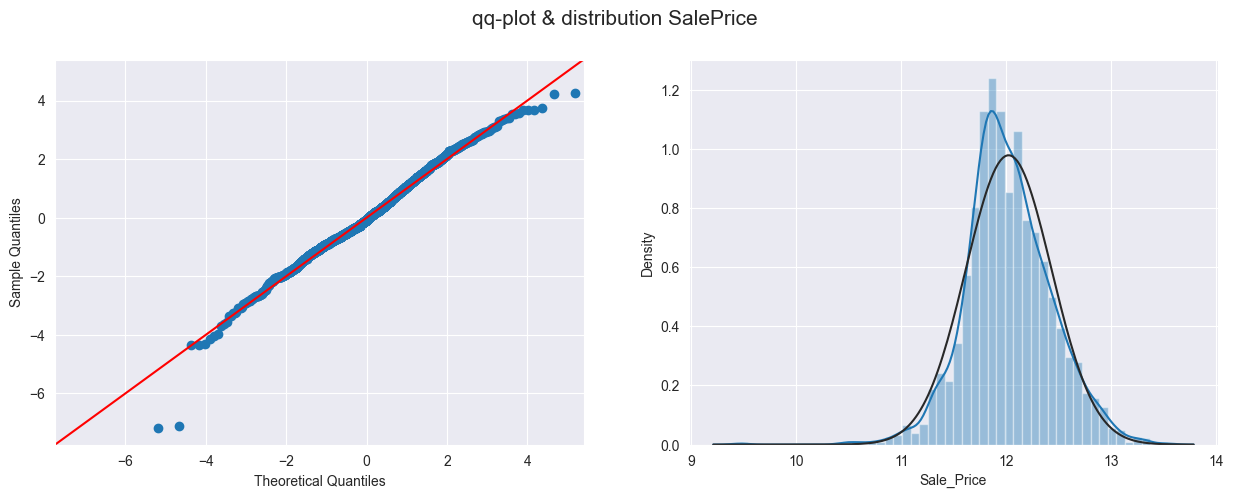

In [425]:
target_log = np.log(data.Sale_Price)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("qq-plot & distribution SalePrice ", fontsize= 15)

sm.qqplot(target_log, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target_log, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

data.Sale_Price = target_log

# Custom features definition
età della casa quando è stata venduta

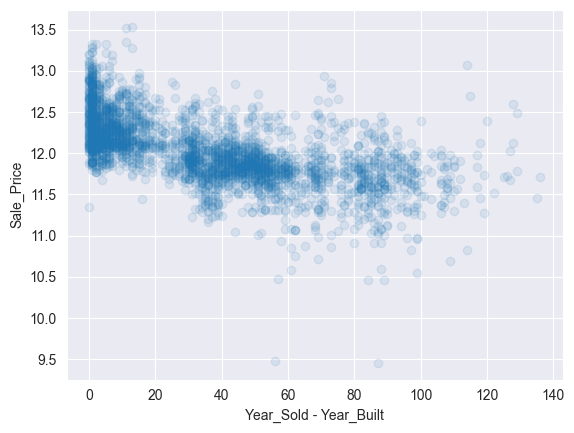

In [426]:
fig, axs = plt.subplots()

axs.plot((data.Year_Sold - data.Year_Built), data.Sale_Price, 'o', alpha=0.1)
axs.set_xlabel('Year_Sold - Year_Built')
axs.set_ylabel('Sale_Price')

data['House_Age'] = (data.Year_Sold - data.Year_Built)

full quality of the house

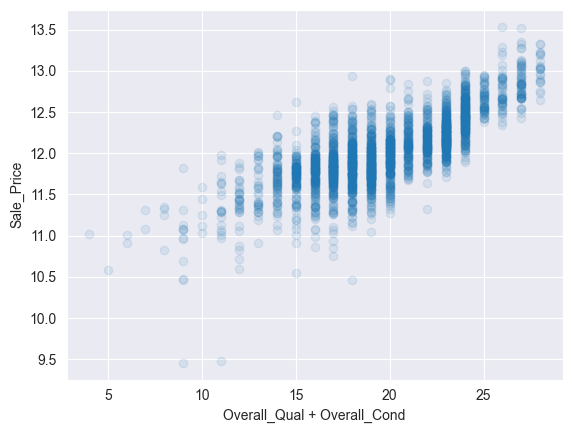

In [427]:
fig, axs = plt.subplots()

axs.plot(data.Overall_Qual + data.Overall_Cond + data.Exter_Qual + data.Exter_Cond + data.Kitchen_Qual, data.Sale_Price, 'o', alpha=0.1)
axs.set_xlabel('Overall_Qual + Overall_Cond')
axs.set_ylabel('Sale_Price')

data['House_Qual'] = data.Overall_Qual + data.Overall_Cond + data.Exter_Qual + data.Exter_Cond + data.Kitchen_Qual

square feet total

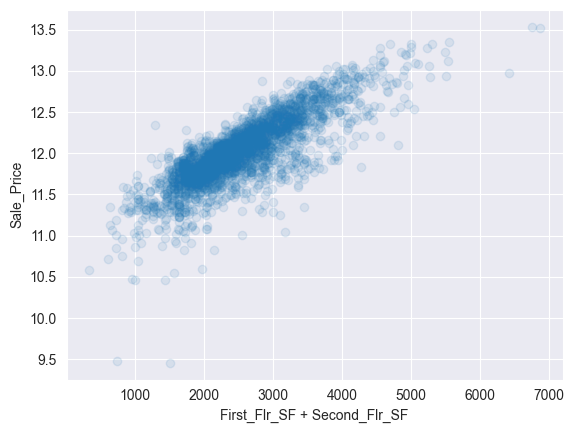

In [428]:
fig, axs = plt.subplots()

axs.plot(data.First_Flr_SF + data.Second_Flr_SF + data.Total_Bsmt_SF, data.Sale_Price, 'o', alpha=0.1)
axs.set_xlabel('First_Flr_SF + Second_Flr_SF')
axs.set_ylabel('Sale_Price')

data['Tot_SF'] = data.First_Flr_SF + data.Second_Flr_SF + data.Total_Bsmt_SF

bagni totali

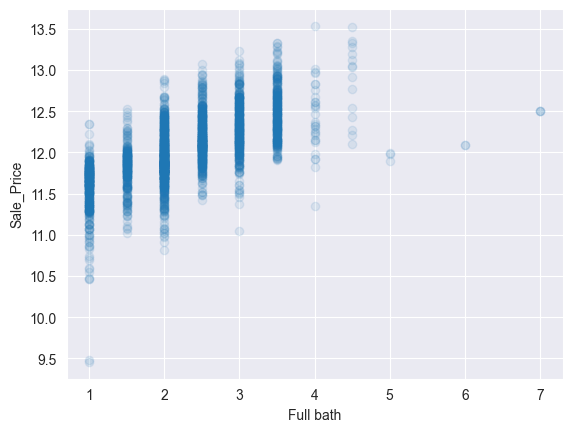

In [429]:
fig, axs = plt.subplots()

axs.plot((data.Full_Bath + (0.5 * data.Half_Bath) +
          data.Bsmt_Full_Bath + (0.5 * data.Bsmt_Half_Bath)), data.Sale_Price, 'o', alpha=0.1)
axs.set_xlabel('Full bath')
axs.set_ylabel('Sale_Price')

data["Full_Bath"] = (data.Full_Bath + (0.5 * data.Half_Bath) + data.Bsmt_Full_Bath + (0.5 * data.Bsmt_Half_Bath))

square feet per room

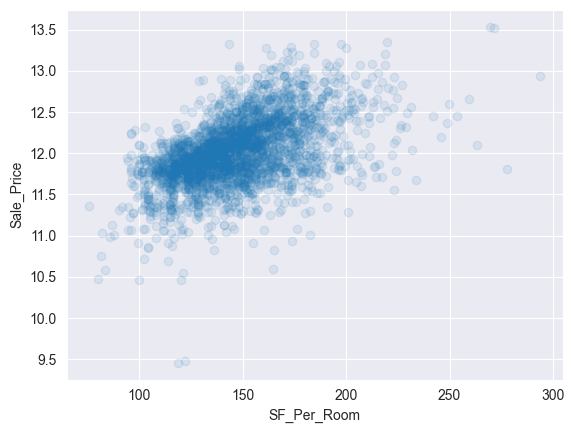

In [430]:
fig, axs = plt.subplots()

axs.plot(data.Gr_Liv_Area / (data.TotRms_AbvGrd +
                                    data.Full_Bath +
                                    data.Half_Bath +
                                    data.Kitchen_AbvGr), data.Sale_Price, 'o', alpha=0.1)
axs.set_xlabel('SF_Per_Room')
axs.set_ylabel('Sale_Price')

data['SF_Per_Room'] = data.Gr_Liv_Area / (data.TotRms_AbvGrd + data.Full_Bath + data.Half_Bath + data.Kitchen_AbvGr)

## Make data split


In [431]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Sale_Price'])
Y = data['Sale_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2341, 83), (586, 83), (2341,), (586,))

## One hot encoding
We are going to OneHotEncode the discrete variable

In [432]:
from sklearn.preprocessing import OneHotEncoder

X_train_numerical = X_train.select_dtypes(include=np.number)
X_test_numerical = X_test.select_dtypes(include=np.number)

categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse=False, handle_unknown='ignore', min_frequency=0.15, max_categories=5)
oh.fit(X_train[categorical_columns])

X_train_e = oh.transform(X_train[categorical_columns])
X_test_e = oh.transform(X_test[categorical_columns])

for i, col in enumerate(oh.get_feature_names_out()):
    X_train_numerical[col] = X_train_e[:, i]

for i, col in enumerate(oh.get_feature_names_out()):
    X_test_numerical[col] = X_test_e[:, i]

#TODO we can try to defragment dataframe

X_train = X_train_numerical
X_test = X_test_numerical

X_train.shape, X_test.shape

((2341, 141), (586, 141))

# Studio della correlazione

Top 50% Corralation train attributes with sale-price

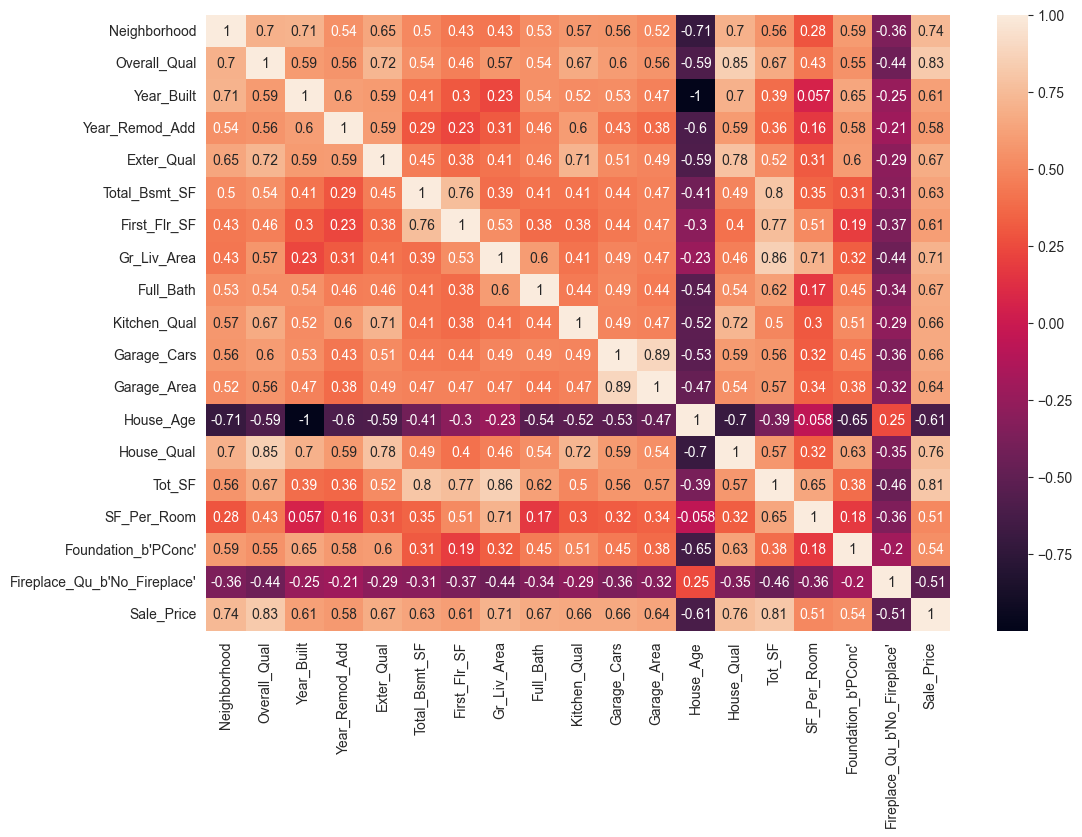

In [433]:
XY_train = pd.concat([X_train, Y_train], axis=1)
corr = XY_train.corr()

top_feature = corr.index[abs(corr['Sale_Price']) > 0.5]
plt.subplots(figsize=(12, 8))
top_corr = XY_train[top_feature].corr()
sns.heatmap(top_corr, annot=True)
plt.show()

# Feature importance

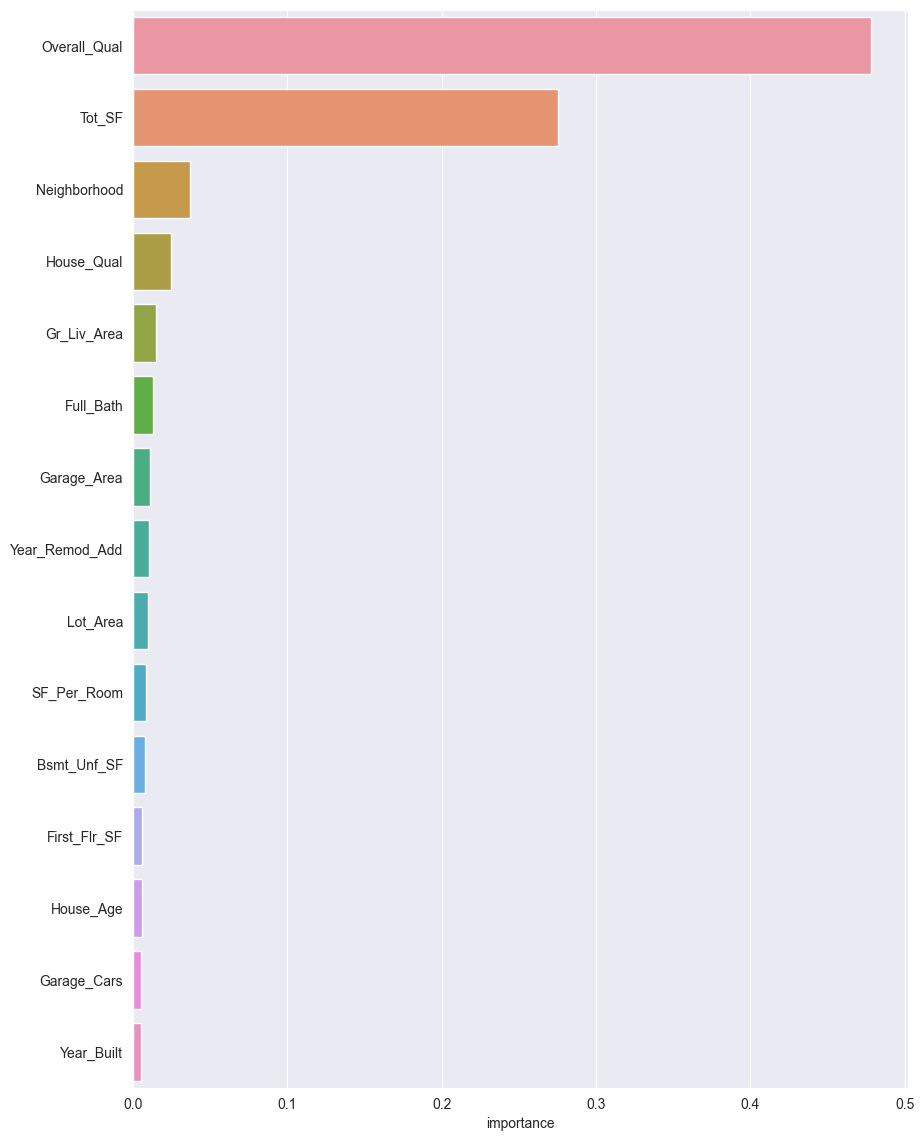

In [434]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=500)
rnd_reg.fit(X_train, Y_train)

feature_importances = pd.DataFrame(rnd_reg.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 14))
sns.barplot(x="importance", y=feature_importances.index[:15], data=feature_importances[:15])
plt.show()

griglia di plot che ci aiuta a vedere se vi è multicolinearità tra alcune feature

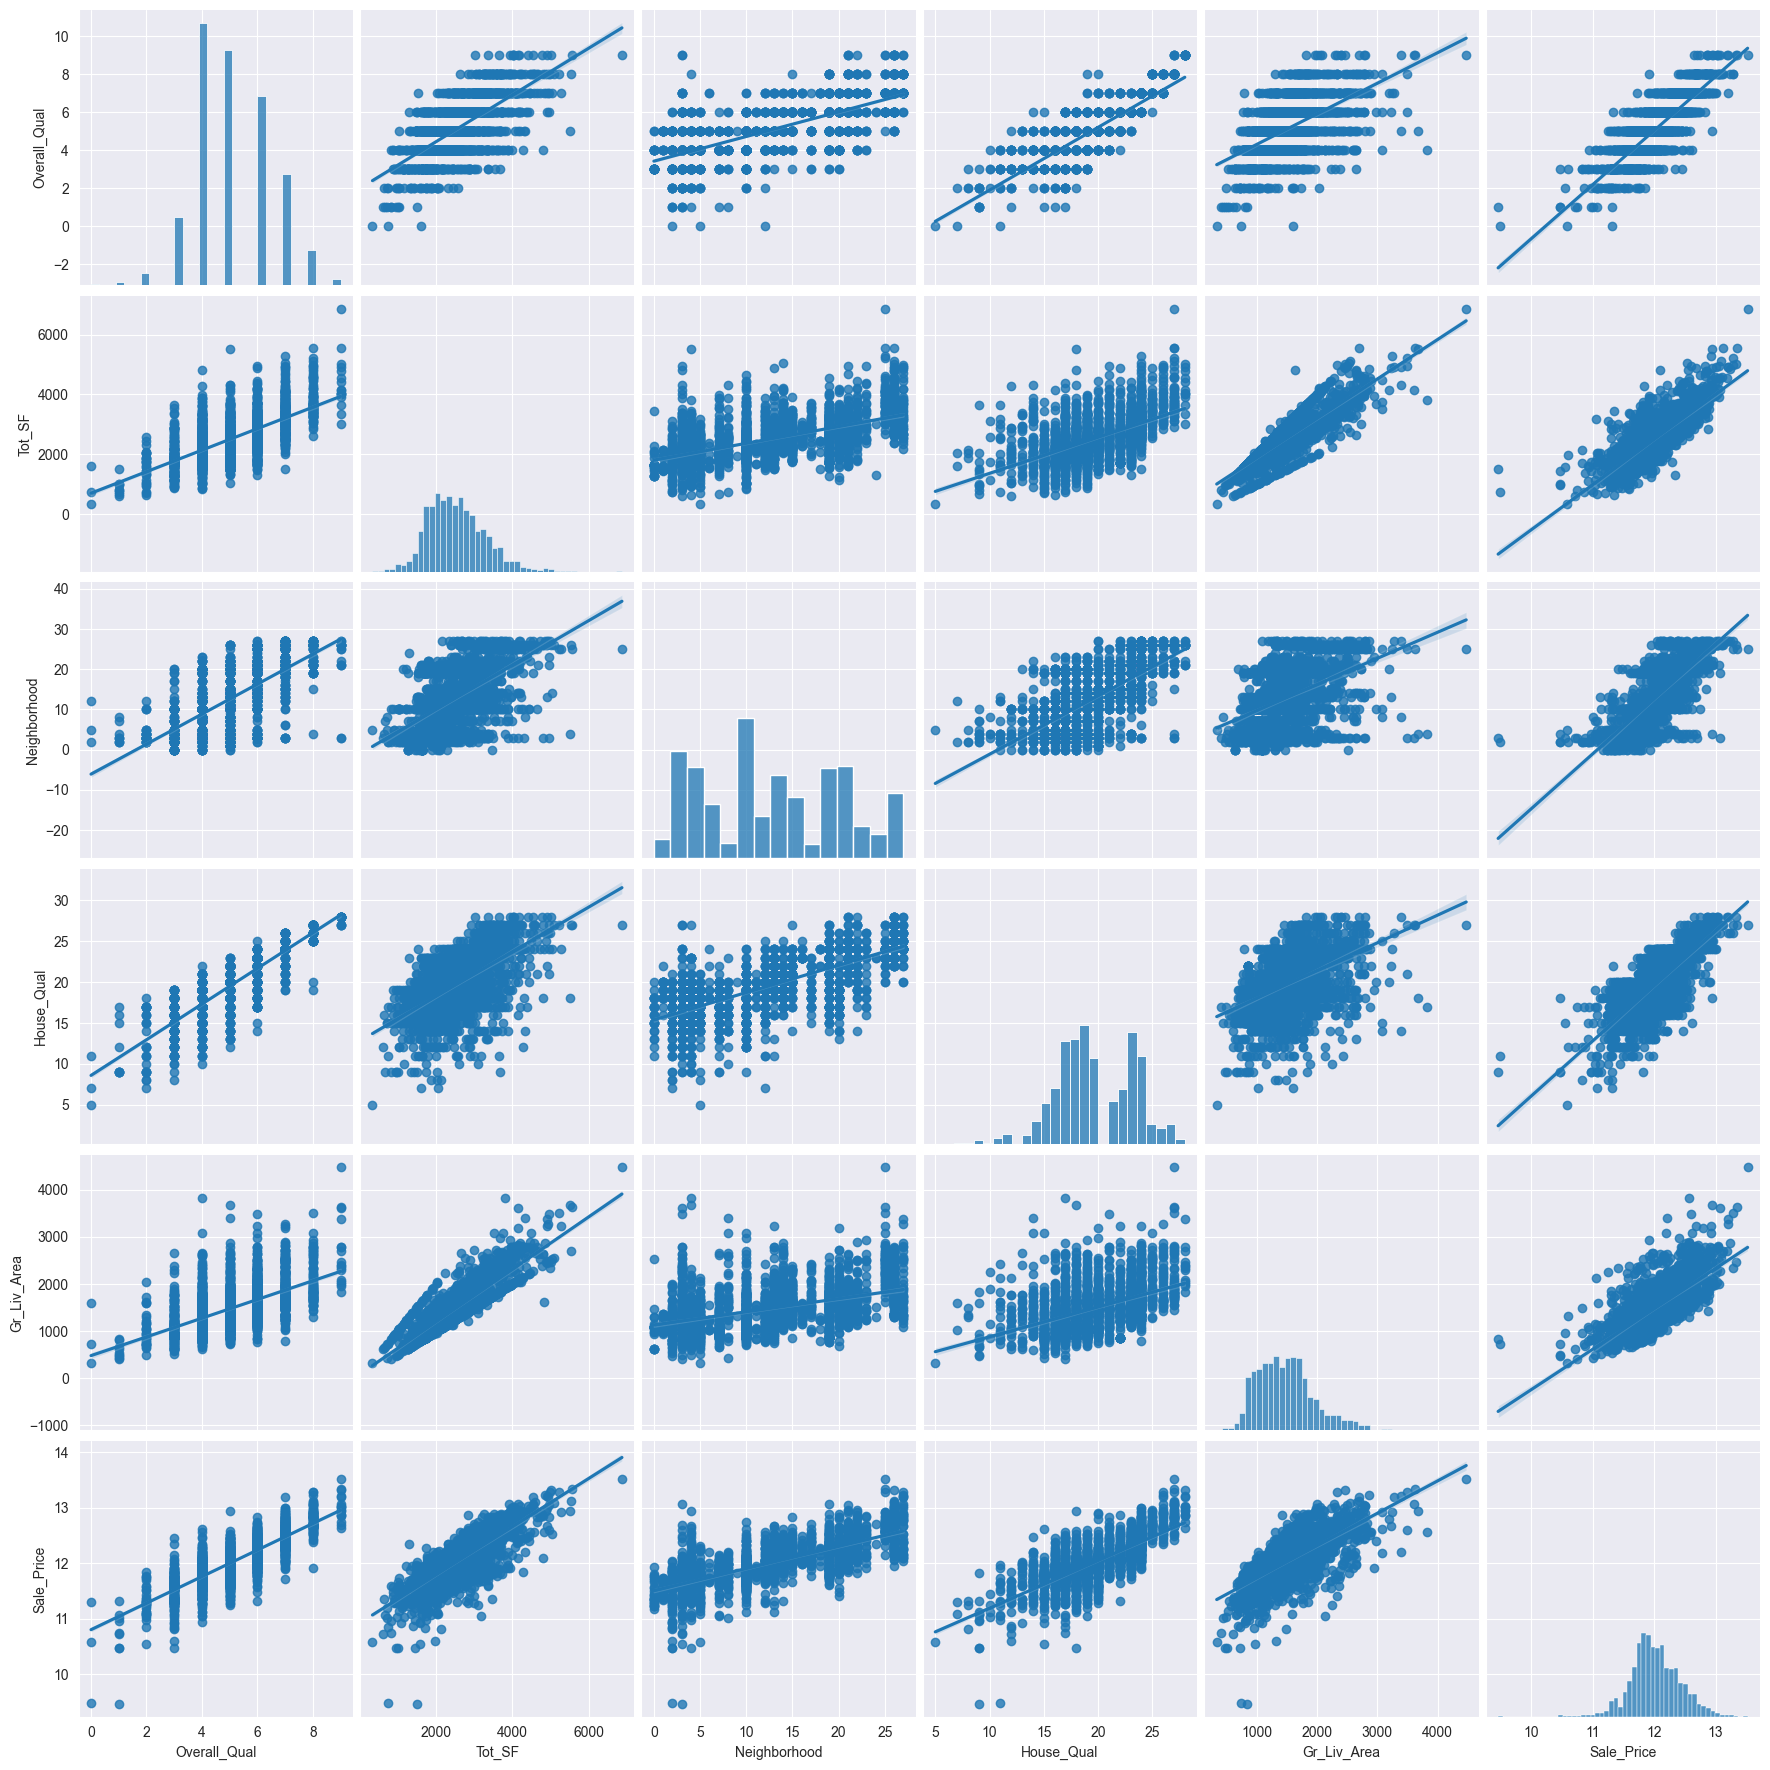

In [435]:
col = feature_importances[:5].index
col = col.to_list() + ['Sale_Price']
sns.pairplot(XY_train[col], height=3, kind='reg')

# Some plot for correlatted features

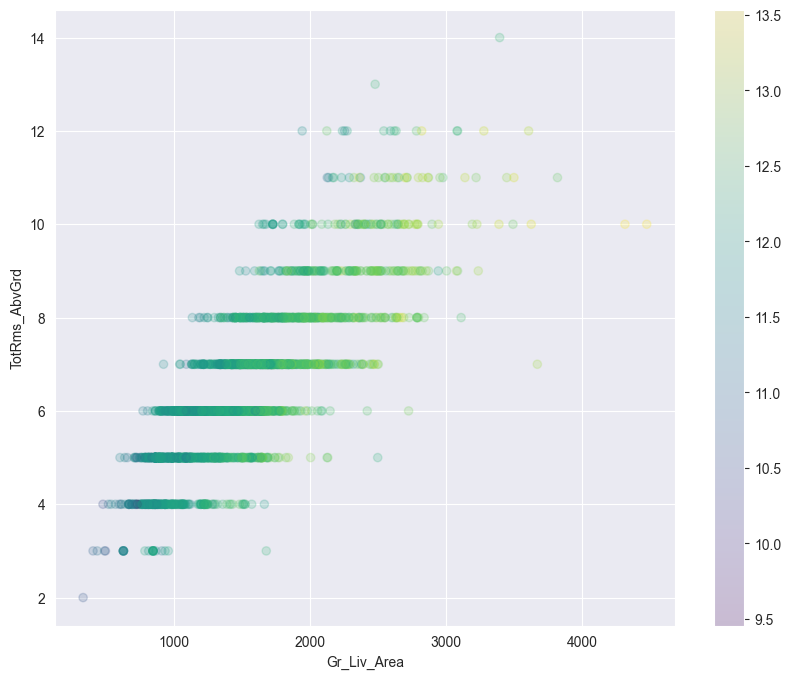

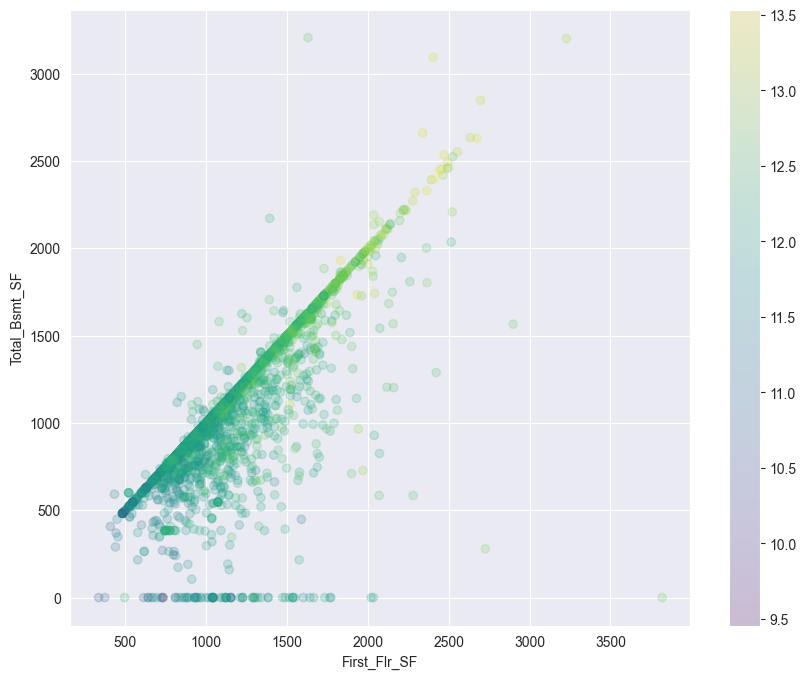

In [436]:
fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.Gr_Liv_Area, data.TotRms_AbvGrd, c=data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('Gr_Liv_Area')
axs.set_ylabel('TotRms_AbvGrd')
fig.colorbar(pos)
plt.show()

fig, axs = plt.subplots(figsize=(10, 8))

pos = plt.scatter(data.First_Flr_SF, data.Total_Bsmt_SF, c=data.Sale_Price, cmap="viridis", alpha=0.2)
axs.set_xlabel('First_Flr_SF')
axs.set_ylabel('Total_Bsmt_SF')
fig.colorbar(pos)
plt.show()

# Save dataframe in a csv file

In [437]:
X_train.to_csv('./data/X_train.csv', index=False)
X_test.to_csv('./data/X_test.csv', index=False)
Y_train.to_csv('./data/Y_train.csv', index=False)
Y_test.to_csv('./data/Y_test.csv', index=False)